Loading CIFAR-10 dataset...
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Dataset loaded: 50000 training samples, 10000 test samples
Image shape: (32, 32, 3) (color), (32, 32) (grayscale)


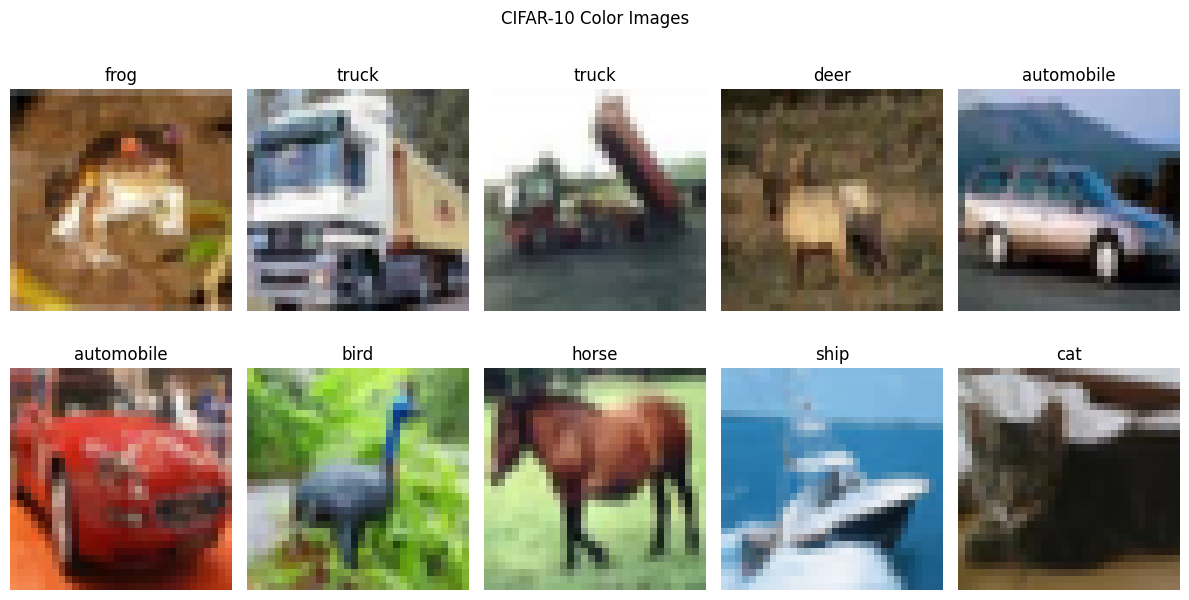

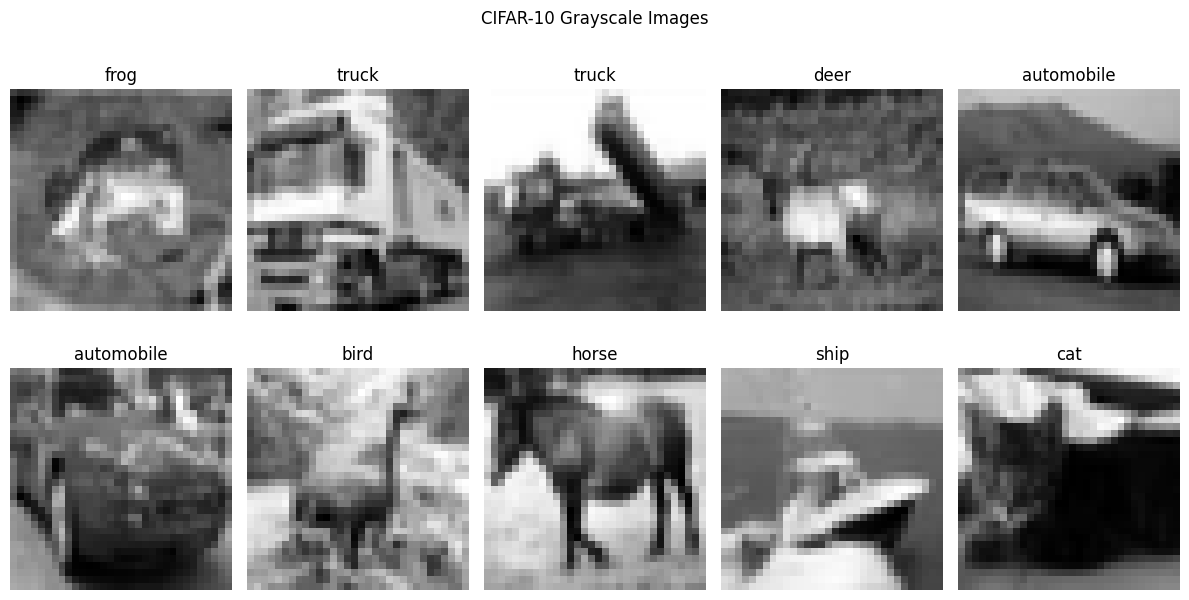

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split


print("Loading CIFAR-10 dataset...")
(X_train_full, y_train_full), (X_test_full, y_test_full) = cifar10.load_data()

# Convert to grayscale
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

# Create grayscale versions
X_train_gray = np.array([rgb2gray(img) for img in X_train_full])
X_test_gray = np.array([rgb2gray(img) for img in X_test_full])

# Normalize data
X_train_full = X_train_full.astype('float32') / 255.0
X_test_full = X_test_full.astype('float32') / 255.0
X_train_gray = X_train_gray.astype('float32') / 255.0
X_test_gray = X_test_gray.astype('float32') / 255.0

# Flatten labels
y_train_full = y_train_full.flatten()
y_test_full = y_test_full.flatten()

# Define class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

print(f"Dataset loaded: {X_train_full.shape[0]} training samples, {X_test_full.shape[0]} test samples")
print(f"Image shape: {X_train_full.shape[1:]} (color), {X_train_gray.shape[1:]} (grayscale)")

# Display some sample images
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_train_full[i])
    plt.title(class_names[y_train_full[i]])
    plt.axis('off')
plt.tight_layout()
plt.suptitle("CIFAR-10 Color Images", y=1.05)
plt.show()

# Display corresponding grayscale images
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_train_gray[i], cmap='gray')
    plt.title(class_names[y_train_full[i]])
    plt.axis('off')
plt.tight_layout()
plt.suptitle("CIFAR-10 Grayscale Images", y=1.05)
plt.show()

Converting images to grayscale...
Extracting HOG features...
HOG feature extraction time: 7.18 seconds
HOG feature vector length: 324


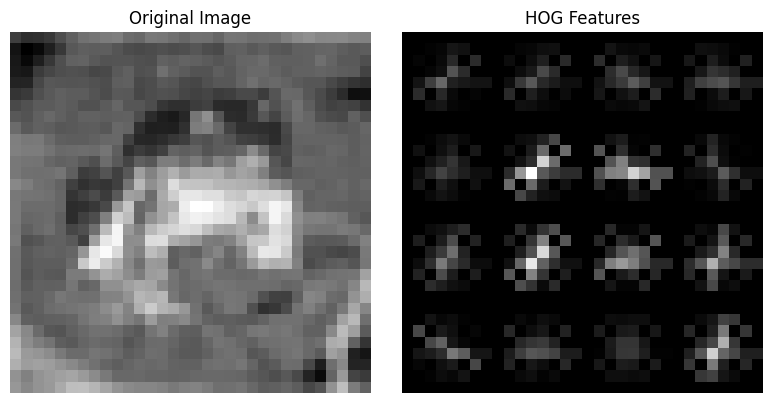

Training Logistic Regression classifier on HOG features...
Training time: 3.81 seconds
Inference time: 0.01 seconds
Accuracy: 0.4810
Precision: 0.4808
Recall: 0.4810
F1 Score: 0.4797

Classification Report:
              precision    recall  f1-score   support

    airplane       0.47      0.52      0.50       103
  automobile       0.52      0.56      0.54        89
        bird       0.43      0.42      0.43       100
         cat       0.41      0.33      0.37       103
        deer       0.39      0.40      0.39        90
         dog       0.36      0.36      0.36        86
        frog       0.50      0.57      0.53       112
       horse       0.55      0.53      0.54       102
        ship       0.57      0.50      0.53       106
       truck       0.58      0.58      0.58       109

    accuracy                           0.48      1000
   macro avg       0.48      0.48      0.48      1000
weighted avg       0.48      0.48      0.48      1000



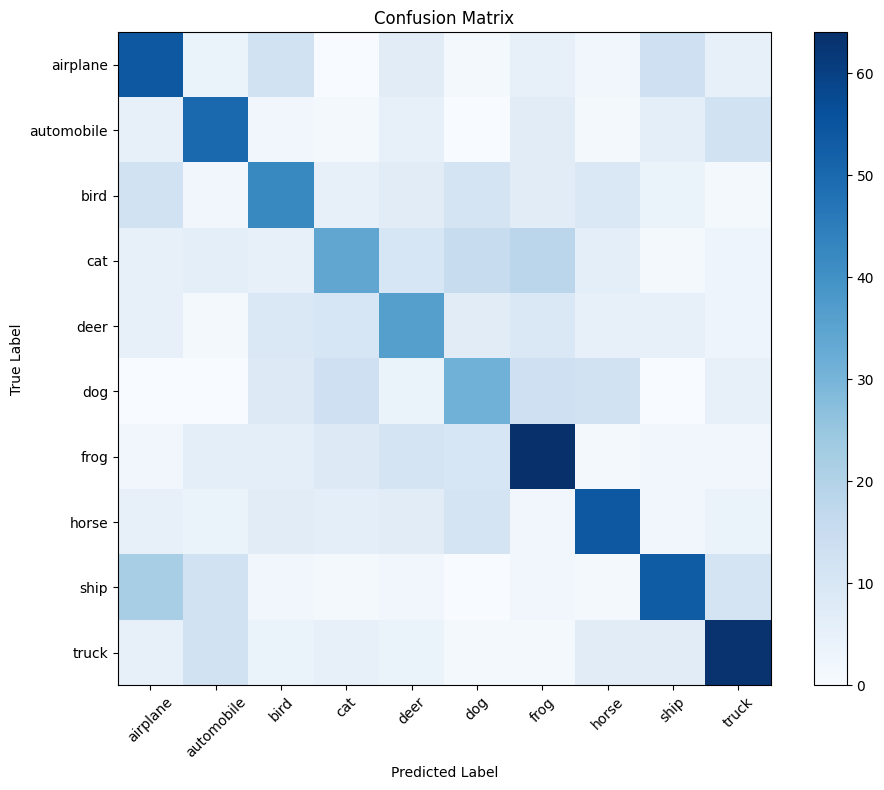

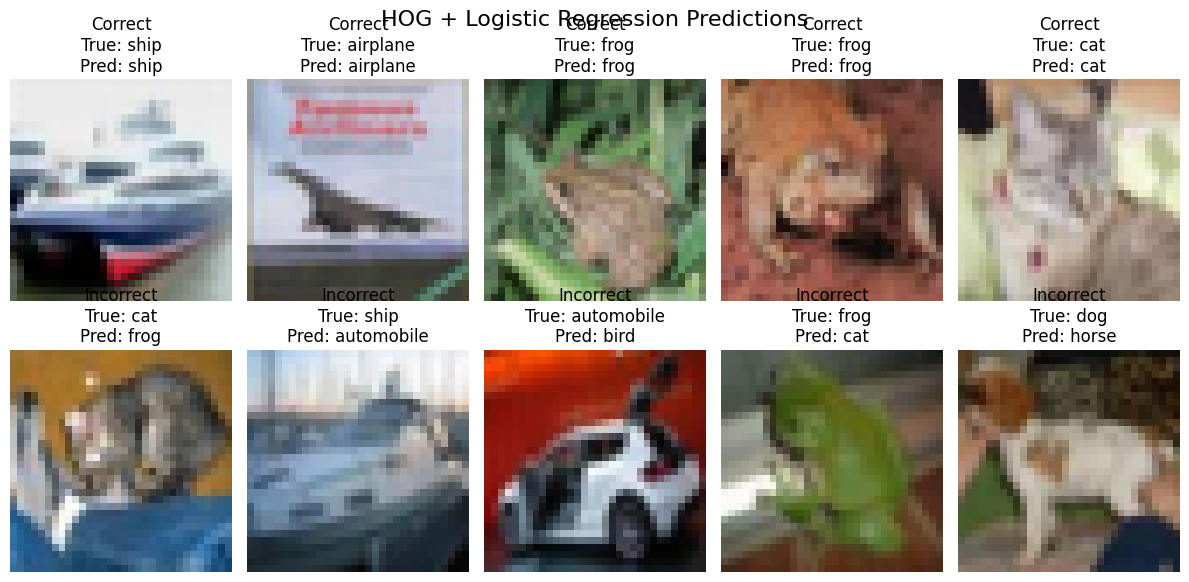

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import time
from tensorflow.keras.datasets import cifar10
from skimage.color import rgb2gray

# Load data if not already loaded
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

# Class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Preprocess images for HOG
def preprocess_for_hog(images):
    return np.array([rgb2gray(img) for img in images])

# Extract HOG features
def extract_hog_features(images, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2)):
    features = []
    for img in images:
        fd = hog(img, orientations=orientations,
                pixels_per_cell=pixels_per_cell,
                cells_per_block=cells_per_block,
                block_norm='L2-Hys',
                visualize=False)
        features.append(fd)
    return np.array(features)

# Convert images to grayscale
print("Converting images to grayscale...")
X_train_gray = preprocess_for_hog(X_train[:5000])  # Using a subset
X_test_gray = preprocess_for_hog(X_test[:1000])
y_train_subset = y_train[:5000]
y_test_subset = y_test[:1000]

# Extract HOG features
print("Extracting HOG features...")
start_time = time.time()
X_train_hog = extract_hog_features(X_train_gray)
X_test_hog = extract_hog_features(X_test_gray)
hog_extraction_time = time.time() - start_time
print(f"HOG feature extraction time: {hog_extraction_time:.2f} seconds")
print(f"HOG feature vector length: {X_train_hog.shape[1]}")

# Visualize HOG features for a sample image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

sample_img = X_train_gray[0]
hog_features, hog_image = hog(sample_img, orientations=9,
                            pixels_per_cell=(8, 8),
                            cells_per_block=(2, 2),
                            block_norm='L2-Hys',
                            visualize=True)

ax1.imshow(sample_img, cmap='gray')
ax1.set_title('Original Image')
ax1.axis('off')

hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.imshow(hog_image_rescaled, cmap='gray')
ax2.set_title('HOG Features')
ax2.axis('off')
plt.tight_layout()
plt.show()

# Train a classifier
print("Training Logistic Regression classifier on HOG features...")
start_time = time.time()
clf = LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1)
clf.fit(X_train_hog, y_train_subset)
training_time = time.time() - start_time
print(f"Training time: {training_time:.2f} seconds")

start_time = time.time()
y_pred = clf.predict(X_test_hog)
inference_time = time.time() - start_time
print(f"Inference time: {inference_time:.2f} seconds")

accuracy = accuracy_score(y_test_subset, y_pred)
precision = precision_score(y_test_subset, y_pred, average='weighted')
recall = recall_score(y_test_subset, y_pred, average='weighted')
f1 = f1_score(y_test_subset, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_subset, y_pred, target_names=class_names))

cm = confusion_matrix(y_test_subset, y_pred)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Show examples of correct and incorrect predictions
plt.figure(figsize=(12, 6))
correct_idx = np.where(y_pred == y_test_subset)[0]
incorrect_idx = np.where(y_pred != y_test_subset)[0]


for i in range(5):
    if i < len(correct_idx):
        plt.subplot(2, 5, i+1)
        plt.imshow(X_test[correct_idx[i]], cmap='gray')
        plt.title(f"Correct\nTrue: {class_names[y_test_subset[correct_idx[i]]]}\nPred: {class_names[y_pred[correct_idx[i]]]}")
        plt.axis('off')


for i in range(5):
    if i < len(incorrect_idx):
        plt.subplot(2, 5, i+6)
        plt.imshow(X_test[incorrect_idx[i]], cmap='gray')
        plt.title(f"Incorrect\nTrue: {class_names[y_test_subset[incorrect_idx[i]]]}\nPred: {class_names[y_pred[incorrect_idx[i]]]}")
        plt.axis('off')

plt.tight_layout()
plt.suptitle("HOG + Logistic Regression Predictions", fontsize=16)
plt.subplots_adjust(top=0.88)
plt.show()

Converting images to grayscale...
Extracting LBP features...


/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


LBP feature extraction time: 1.90 seconds
LBP feature vector length: 10


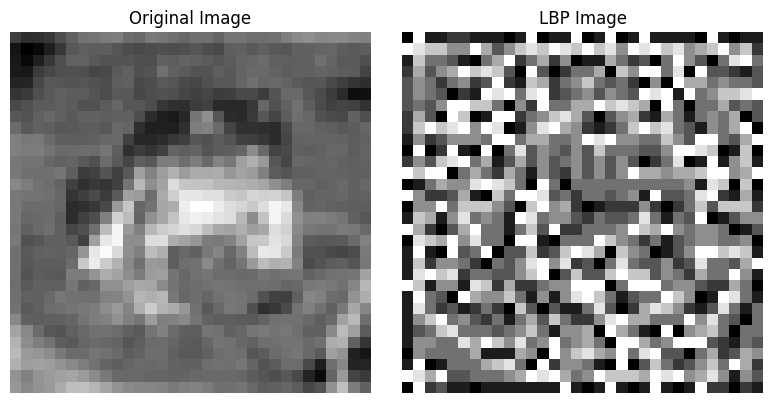

Training Logistic Regression classifier on LBP features...
Training time: 1.94 seconds
Inference time: 0.00 seconds
Accuracy: 0.2210
Precision: 0.3091
Recall: 0.2210
F1 Score: 0.1787

Classification Report:
              precision    recall  f1-score   support

    airplane       0.25      0.22      0.23       103
  automobile       0.29      0.20      0.24        89
        bird       0.09      0.02      0.03       100
         cat       0.45      0.05      0.09       103
        deer       0.14      0.26      0.18        90
         dog       0.17      0.29      0.22        86
        frog       0.28      0.71      0.40       112
       horse       1.00      0.01      0.02       102
        ship       0.21      0.35      0.26       106
       truck       0.18      0.07      0.10       109

    accuracy                           0.22      1000
   macro avg       0.31      0.22      0.18      1000
weighted avg       0.31      0.22      0.18      1000



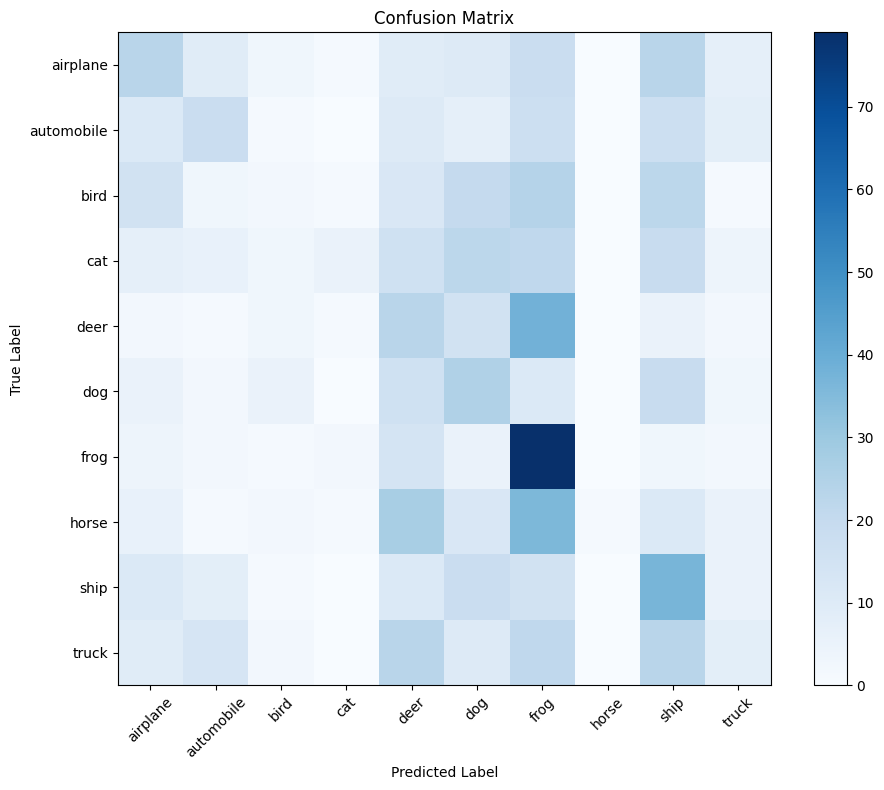

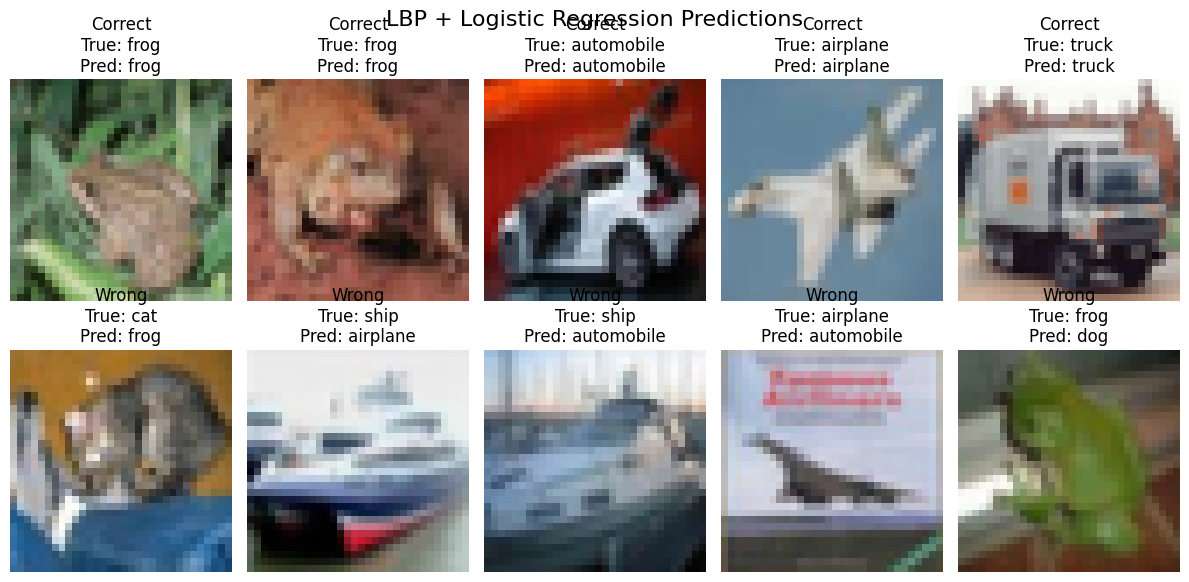

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
from skimage import exposure
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import time
from tensorflow.keras.datasets import cifar10
from skimage.color import rgb2gray

# Load CIFAR-10 data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Preprocess images to grayscale
def preprocess_images(images):
    return np.array([rgb2gray(img) for img in images])

# Extract LBP features
def extract_lbp_features(images, P=8, R=1.0, method='uniform'):
    features = []
    for img in images:
        lbp = local_binary_pattern(img, P, R, method)
        (hist, _) = np.histogram(lbp.ravel(),
                                 bins=np.arange(0, P + 3),
                                 range=(0, P + 2),
                                 density=True)
        features.append(hist)
    return np.array(features)

# Convert to grayscale
print("Converting images to grayscale...")
X_train_gray = preprocess_images(X_train[:5000])
X_test_gray = preprocess_images(X_test[:1000])
y_train_subset = y_train[:5000]
y_test_subset = y_test[:1000]

# Extract LBP features
print("Extracting LBP features...")
start_time = time.time()
X_train_lbp = extract_lbp_features(X_train_gray, P=8, R=1.0, method='uniform')
X_test_lbp = extract_lbp_features(X_test_gray, P=8, R=1.0, method='uniform')
lbp_extraction_time = time.time() - start_time
print(f"LBP feature extraction time: {lbp_extraction_time:.2f} seconds")
print(f"LBP feature vector length: {X_train_lbp.shape[1]}")

# Visualize sample image with LBP
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
sample_img = X_train_gray[0]
lbp_img = local_binary_pattern(sample_img, P=8, R=1.0, method='uniform')

ax1.imshow(sample_img, cmap='gray')
ax1.set_title('Original Image')
ax1.axis('off')

ax2.imshow(lbp_img, cmap='gray')
ax2.set_title('LBP Image')
ax2.axis('off')
plt.tight_layout()
plt.show()

# Train Logistic Regression model
print("Training Logistic Regression classifier on LBP features...")
start_time = time.time()
clf = LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1)
clf.fit(X_train_lbp, y_train_subset)
training_time = time.time() - start_time
print(f"Training time: {training_time:.2f} seconds")

start_time = time.time()
y_pred = clf.predict(X_test_lbp)
inference_time = time.time() - start_time
print(f"Inference time: {inference_time:.2f} seconds")

# Evaluation Metrics
accuracy = accuracy_score(y_test_subset, y_pred)
precision = precision_score(y_test_subset, y_pred, average='weighted')
recall = recall_score(y_test_subset, y_pred, average='weighted')
f1 = f1_score(y_test_subset, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_subset, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_test_subset, y_pred)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Show correct & incorrect predictions
plt.figure(figsize=(12, 6))
correct_idx = np.where(y_pred == y_test_subset)[0]
incorrect_idx = np.where(y_pred != y_test_subset)[0]

for i in range(5):
    if i < len(correct_idx):
        plt.subplot(2, 5, i+1)
        plt.imshow(X_test[correct_idx[i]])
        plt.title(f"Correct\nTrue: {class_names[y_test_subset[correct_idx[i]]]}\nPred: {class_names[y_pred[correct_idx[i]]]}")
        plt.axis('off')

for i in range(5):
    if i < len(incorrect_idx):
        plt.subplot(2, 5, i+6)
        plt.imshow(X_test[incorrect_idx[i]])
        plt.title(f"Wrong\nTrue: {class_names[y_test_subset[incorrect_idx[i]]]}\nPred: {class_names[y_pred[incorrect_idx[i]]]}")
        plt.axis('off')

plt.tight_layout()
plt.suptitle("LBP + Logistic Regression Predictions", fontsize=16)
plt.subplots_adjust(top=0.88)
plt.show()


Converting images to grayscale...
Extracting Edge Detection features...
Edge feature extraction time: 3.91 seconds
Edge feature vector length: 1024


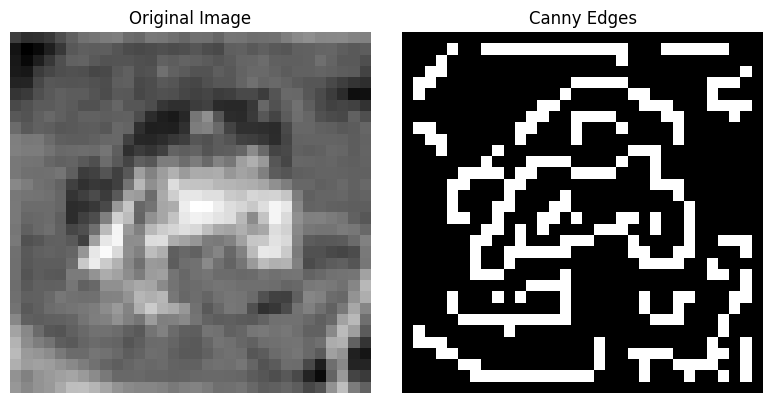

Training Random Forest classifier on Edge features...
Training time: 3.79 seconds
Inference time: 0.06 seconds
Accuracy: 0.1800
Precision: 0.1719
Recall: 0.1800
F1 Score: 0.1728

Classification Report:
              precision    recall  f1-score   support

    airplane       0.28      0.38      0.32       103
  automobile       0.15      0.10      0.12        89
        bird       0.19      0.24      0.21       100
         cat       0.15      0.15      0.15       103
        deer       0.16      0.23      0.19        90
         dog       0.08      0.07      0.07        86
        frog       0.21      0.19      0.20       112
       horse       0.11      0.07      0.08       102
        ship       0.19      0.23      0.21       106
       truck       0.17      0.13      0.15       109

    accuracy                           0.18      1000
   macro avg       0.17      0.18      0.17      1000
weighted avg       0.17      0.18      0.17      1000



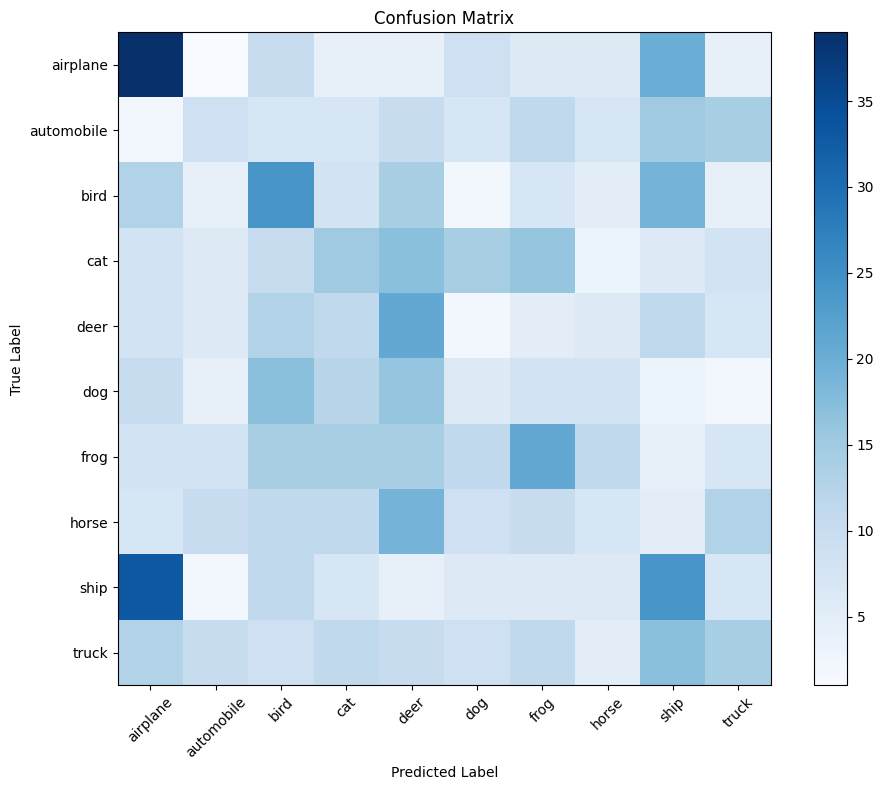

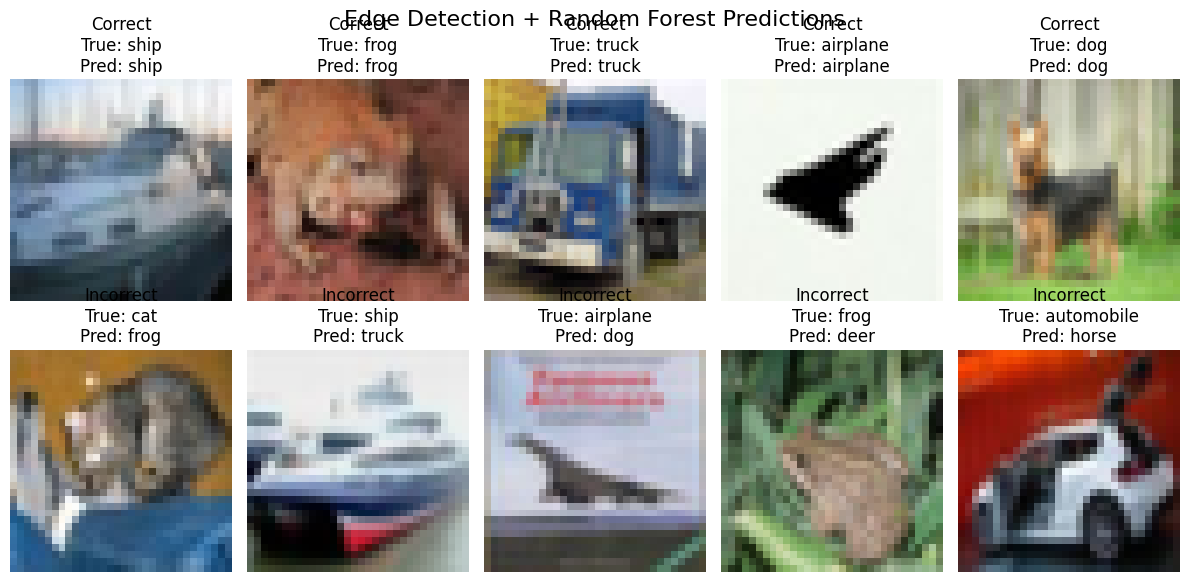

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import feature
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import time
from tensorflow.keras.datasets import cifar10
from skimage.color import rgb2gray

# Load CIFAR-10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

# Class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Convert images to grayscale
def preprocess_grayscale(images):
    return np.array([rgb2gray(img) for img in images])

# Extract edge features using Canny
def extract_edge_features(images, sigma=1.0):
    features = []
    for img in images:
        edges = feature.canny(img, sigma=sigma)
        features.append(edges.flatten())  # Flatten to 1D feature vector
    return np.array(features)

# Preprocessing
print("Converting images to grayscale...")
X_train_gray = preprocess_grayscale(X_train[:5000])  # Subset for speed
X_test_gray = preprocess_grayscale(X_test[:1000])
y_train_subset = y_train[:5000]
y_test_subset = y_test[:1000]

# Edge Detection
print("Extracting Edge Detection features...")
start_time = time.time()
X_train_edges = extract_edge_features(X_train_gray, sigma=1.0)
X_test_edges = extract_edge_features(X_test_gray, sigma=1.0)
edge_extraction_time = time.time() - start_time
print(f"Edge feature extraction time: {edge_extraction_time:.2f} seconds")
print(f"Edge feature vector length: {X_train_edges.shape[1]}")

# Visualize Edge Detection
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
sample_img = X_train_gray[0]
sample_edge = feature.canny(sample_img, sigma=1.0)

ax1.imshow(sample_img, cmap='gray')
ax1.set_title("Original Image")
ax1.axis('off')

ax2.imshow(sample_edge, cmap='gray')
ax2.set_title("Canny Edges")
ax2.axis('off')

plt.tight_layout()
plt.show()

# Train Classifier (Random Forest)
print("Training Random Forest classifier on Edge features...")
start_time = time.time()
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(X_train_edges, y_train_subset)
training_time = time.time() - start_time
print(f"Training time: {training_time:.2f} seconds")

# Inference
start_time = time.time()
y_pred = clf.predict(X_test_edges)
inference_time = time.time() - start_time
print(f"Inference time: {inference_time:.2f} seconds")

# Evaluation Metrics
accuracy = accuracy_score(y_test_subset, y_pred)
precision = precision_score(y_test_subset, y_pred, average='weighted')
recall = recall_score(y_test_subset, y_pred, average='weighted')
f1 = f1_score(y_test_subset, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_subset, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_test_subset, y_pred)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Visualize Predictions
plt.figure(figsize=(12, 6))
correct_idx = np.where(y_pred == y_test_subset)[0]
incorrect_idx = np.where(y_pred != y_test_subset)[0]

for i in range(5):
    if i < len(correct_idx):
        plt.subplot(2, 5, i + 1)
        plt.imshow(X_test[correct_idx[i]])
        plt.title(f"Correct\nTrue: {class_names[y_test_subset[correct_idx[i]]]}\nPred: {class_names[y_pred[correct_idx[i]]]}")
        plt.axis('off')

for i in range(5):
    if i < len(incorrect_idx):
        plt.subplot(2, 5, i + 6)
        plt.imshow(X_test[incorrect_idx[i]])
        plt.title(f"Incorrect\nTrue: {class_names[y_test_subset[incorrect_idx[i]]]}\nPred: {class_names[y_pred[incorrect_idx[i]]]}")
        plt.axis('off')

plt.tight_layout()
plt.suptitle("Edge Detection + Random Forest Predictions", fontsize=16)
plt.subplots_adjust(top=0.88)
plt.show()


In [ ]:
import numpy as np
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import time

# Load CIFAR-10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
y_train = y_train.flatten()
y_test = y_test.flatten()

# Resize CIFAR-10 images to match ResNet50 input size (224x224x3)
def resize_images(images, size=(224, 224)):
    resized_images = np.zeros((images.shape[0], *size, 3), dtype=np.float32)
    for i in range(images.shape[0]):
        img = array_to_img(images[i])
        img = img.resize(size)
        img = img_to_array(img)
        resized_images[i] = img
    return resized_images

print("Resizing images...")
X_train_resized = resize_images(X_train[:5000])
X_test_resized = resize_images(X_test[:1000])
y_train_subset = y_train[:5000]
y_test_subset = y_test[:1000]

# Preprocess images
X_train_preprocessed = preprocess_input(X_train_resized)
X_test_preprocessed = preprocess_input(X_test_resized)

# Load pre-trained ResNet50 without top layer, add GlobalAveragePooling
print("Loading ResNet50 for feature extraction...")
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))

# Extract deep features
print("Extracting deep features using ResNet50...")
start_time = time.time()
train_features = model.predict(X_train_preprocessed, batch_size=32, verbose=1)
test_features = model.predict(X_test_preprocessed, batch_size=32, verbose=1)
feature_extraction_time = time.time() - start_time
print(f"Feature extraction time: {feature_extraction_time:.2f} seconds")
print(f"Feature vector shape: {train_features.shape}")

# Train classifier on extracted features
print("Training Random Forest classifier on ResNet features...")
start_time = time.time()
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_clf.fit(train_features, y_train_subset)
training_time = time.time() - start_time
print(f"Training time: {training_time:.2f} seconds")

# Predict and evaluate
start_time = time.time()
y_pred = rf_clf.predict(test_features)
inference_time = time.time() - start_time
print(f"Inference time: {inference_time:.2f} seconds")

# Evaluation
accuracy = accuracy_score(y_test_subset, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_subset, y_pred))


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Resizing images...
Loading ResNet50 for feature extraction...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Extracting deep features using ResNet50...
157/157 ━━━━━━━━━━━━━━━━━━━━ 1001s 6s/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 200s 6s/step
Feature extraction time: 1253.71 seconds
Feature vector shape: (5000, 2048)
Training Random Forest classifier on ResNet features...
Training time: 26.55 seconds
Inference time: 0.06 seconds
Accuracy: 0.8540

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.86       103
           1       0.87      0.92      0.90        89
           2       0.80      0.82      0.81       100
           3       0.78      0.67      0.72       103
           4       0.84      0.84      0.84        90
           5       0.77      0.81      0.79        86
           6       0.82      0.91      0.86       112
           7       0.94      0.87      0.90 

In [ ]:
import numpy as np
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
import time

# Load CIFAR-10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
y_train = y_train.flatten()
y_test = y_test.flatten()

# Resize CIFAR-10 images to match ResNet50 input size (224x224x3)
def resize_images(images, size=(224, 224)):
    resized_images = np.zeros((images.shape[0], *size, 3), dtype=np.float32)
    for i in range(images.shape[0]):
        img = array_to_img(images[i])
        img = img.resize(size)
        img = img_to_array(img)
        resized_images[i] = img
    return resized_images

print("Resizing images...")
X_train_resized = resize_images(X_train[:5000])
X_test_resized = resize_images(X_test[:1000])
y_train_subset = y_train[:5000]
y_test_subset = y_test[:1000]

# Preprocess images
X_train_preprocessed = preprocess_input(X_train_resized)
X_test_preprocessed = preprocess_input(X_test_resized)

# Load pre-trained ResNet50 without top layer, add GlobalAveragePooling
print("Loading ResNet50 for feature extraction...")
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))

# Extract deep features
print("Extracting deep features using ResNet50...")
start_time = time.time()
train_features = model.predict(X_train_preprocessed, batch_size=32, verbose=1)
test_features = model.predict(X_test_preprocessed, batch_size=32, verbose=1)
feature_extraction_time = time.time() - start_time
print(f"Feature extraction time: {feature_extraction_time:.2f} seconds")
print(f"Feature vector shape: {train_features.shape}")

# ------------------- XGBOOST -------------------
print("\nTraining XGBoost classifier on ResNet features...")
xgb_clf = xgb.XGBClassifier(n_estimators=100,
                            max_depth=8,
                            learning_rate=0.1,
                            subsample=0.8,
                            colsample_bytree=0.8,
                            use_label_encoder=False,
                            eval_metric='mlogloss',
                            random_state=42,
                            n_jobs=-1)

start_time = time.time()
xgb_clf.fit(train_features, y_train_subset)
xgb_train_time = time.time() - start_time
print(f"XGBoost Training time: {xgb_train_time:.2f} seconds")

start_time = time.time()
y_pred_xgb = xgb_clf.predict(test_features)
xgb_infer_time = time.time() - start_time
print(f"XGBoost Inference time: {xgb_infer_time:.2f} seconds")

xgb_accuracy = accuracy_score(y_test_subset, y_pred_xgb)
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")
print("\nXGBoost Classification Report:")
print(classification_report(y_test_subset, y_pred_xgb))

# ------------------- SVM -------------------
print("\nTraining SVM classifier on ResNet features...")
svm_clf = SVC(kernel='rbf', C=10, gamma='scale')  # You can tune these params

start_time = time.time()
svm_clf.fit(train_features, y_train_subset)
svm_train_time = time.time() - start_time
print(f"SVM Training time: {svm_train_time:.2f} seconds")

start_time = time.time()
y_pred_svm = svm_clf.predict(test_features)
svm_infer_time = time.time() - start_time
print(f"SVM Inference time: {svm_infer_time:.2f} seconds")

svm_accuracy = accuracy_score(y_test_subset, y_pred_svm)
print(f"SVM Accuracy: {svm_accuracy:.4f}")
print("\nSVM Classification Report:")
print(classification_report(y_test_subset, y_pred_svm))


Resizing images...
Loading ResNet50 for feature extraction...
Extracting deep features using ResNet50...
157/157 ━━━━━━━━━━━━━━━━━━━━ 1018s 6s/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 200s 6s/step
Feature extraction time: 1228.87 seconds
Feature vector shape: (5000, 2048)

Training XGBoost classifier on ResNet features...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:32:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Training time: 598.75 seconds
XGBoost Inference time: 0.06 seconds
XGBoost Accuracy: 0.8670

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       103
           1       0.86      0.92      0.89        89
           2       0.85      0.82      0.84       100
           3       0.77      0.77      0.77       103
           4       0.79      0.87      0.83        90
           5       0.84      0.79      0.81        86
           6       0.91      0.90      0.91       112
           7       0.92      0.94      0.93       102
           8       0.90      0.96      0.93       106
           9       0.93      0.84      0.88       109

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000


Training SVM classifier on ResNet features...
SVM Training time: 15.65 seconds
SVM Inference time: 6.46 seco

In [ ]:
import numpy as np
import cv2
import time
from skimage.feature import local_binary_pattern
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
y_train = y_train.flatten()
y_test = y_test.flatten()

# Convert images to grayscale
def convert_to_grayscale(images):
    return np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in images])

print("Converting images to grayscale...")
X_train_gray = convert_to_grayscale(X_train[:5000])  # Use a subset for faster training
X_test_gray = convert_to_grayscale(X_test[:1000])

# Resize images to 64x64 (smaller size for LBP feature extraction)
def resize_images(images, size=(64, 64)):
    return np.array([cv2.resize(img, size) for img in images])

print("Resizing images...")
X_train_resized = resize_images(X_train_gray)
X_test_resized = resize_images(X_test_gray)

# Normalize images
X_train_norm = X_train_resized / 255.0
X_test_norm = X_test_resized / 255.0

# Extract LBP features
def extract_lbp_features(images, radius=1, n_points=8):
    lbp_features = []
    for img in images:
        lbp = local_binary_pattern(img, P=n_points, R=radius, method="uniform")
        (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        hist = hist.astype("float")
        hist /= hist.sum()  # Normalize the histogram
        lbp_features.append(hist)
    return np.array(lbp_features)

print("Extracting LBP features...")
X_train_lbp = extract_lbp_features(X_train_norm)
X_test_lbp = extract_lbp_features(X_test_norm)

# Standardize the features
scaler = StandardScaler()
X_train_lbp = scaler.fit_transform(X_train_lbp)
X_test_lbp = scaler.transform(X_test_lbp)

# Define classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100)
}

# Train & Evaluate models
results = {}

for name, clf in classifiers.items():
    print(f"\nTraining {name}...")
    start_time = time.time()
    clf.fit(X_train_lbp, y_train[:5000])
    train_time = time.time() - start_time

    # Make predictions
    start_time = time.time()
    y_pred = clf.predict(X_test_lbp)
    infer_time = time.time() - start_time

    # Compute metrics
    accuracy = accuracy_score(y_test[:1000], y_pred)
    report = classification_report(y_test[:1000], y_pred, output_dict=True)

    # Store results
    results[name] = {
        "accuracy": accuracy,
        "precision": report["weighted avg"]["precision"],
        "recall": report["weighted avg"]["recall"],
        "f1-score": report["weighted avg"]["f1-score"],
        "train_time": train_time,
        "infer_time": infer_time
    }

    print(f"{name} Accuracy: {accuracy:.4f}")
    print(classification_report(y_test[:1000], y_pred))

# Display results
import pandas as pd
df_results = pd.DataFrame(results).T
print("\nFinal Comparison:")
print(df_results)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Converting images to grayscale...
Resizing images...
Extracting LBP features...


/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(



Training Logistic Regression...
Logistic Regression Accuracy: 0.2840
              precision    recall  f1-score   support

           0       0.34      0.36      0.35       103
           1       0.29      0.39      0.34        89
           2       0.18      0.14      0.16       100
           3       0.22      0.07      0.10       103
           4       0.28      0.44      0.34        90
           5       0.22      0.34      0.26        86
           6       0.39      0.54      0.45       112
           7       0.24      0.10      0.14       102
           8       0.29      0.25      0.27       106
           9       0.26      0.23      0.24       109

    accuracy                           0.28      1000
   macro avg       0.27      0.29      0.27      1000
weighted avg       0.27      0.28      0.27      1000


Training KNN...
KNN Accuracy: 0.2410
              precision    recall  f1-score   support

           0       0.23      0.34      0.28       103
           1       0.19 

In [ ]:
import numpy as np
from skimage.feature import hog, local_binary_pattern
from skimage import color
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from skimage.transform import resize

# Load CIFAR-10 dataset
cifar = fetch_openml('CIFAR_10', version=1, as_frame=False)
X, y = cifar['data'], cifar['target']

# Reshape images to (N, 32, 32, 3)
X_images = X.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

## Enhanced Feature Extraction
def extract_features(images):
    hog_features = []
    lbp_features = []

    for img in images:
        # Multi-channel HOG (process each color channel)
        hog_r = hog(img[:,:,0], orientations=12, pixels_per_cell=(6, 6),
                   cells_per_block=(3, 3), feature_vector=True)
        hog_g = hog(img[:,:,1], orientations=12, pixels_per_cell=(6, 6),
                   cells_per_block=(3, 3), feature_vector=True)
        hog_b = hog(img[:,:,2], orientations=12, pixels_per_cell=(6, 6),
                   cells_per_block=(3, 3), feature_vector=True)

        # LBP features (on grayscale)
        gray = color.rgb2gray(img)
        lbp = local_binary_pattern(gray, P=16, R=2, method='uniform')
        lbp_hist, _ = np.histogram(lbp, bins=32, range=(0, 32))

        # Concatenate all features
        combined = np.concatenate([hog_r, hog_g, hog_b, lbp_hist])
        hog_features.append(combined)

    return np.array(hog_features)

X_features = extract_features(X_images)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Optimized Classifier (Random Forest)
clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

clf.fit(X_train, y_train)

# Evaluation
y_pred = clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-cc954ca52dc8>", line 63, in <cell line: 0>
    clf.fit(X_train, y_train)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py", line 487, in fit
    trees = Parallel(
            ^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/parallel.py", line 77, in __call__
    return super().__call__(iterable_with_config)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/joblib/parallel.py", line 2007, in __call__
    return output if self.return_generator else list(output)
                              

TypeError: object of type 'NoneType' has no len()